# Moduł LLM - Autoregresyjne modele językowe (modele tylko-dekoder) - Laboratorium

In [ ]:
# fix

Notatnik omawia:

*   Tokenizację tekstów w języku naturalnym z wykorzystaniem tokenizatora BPE
*   Architekturę współczesnych autoregresyjnych modeli językowych (tylko-dekoder) klasy GPT
*   Wstępne trenowanie (*pretraining*) wielkiego modelu językowego w sposób samonadzorowany na zadaniu statystycznego modelowania języka
*   Strategie generowania tekstu







In [1]:
!nvidia-smi

Sat Apr 19 10:17:58 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Import przydatnych bibliotek

In [2]:
import numpy as np
import pickle

import torch
import torch.nn as nn
from torch import Tensor

# Moduły biblioteki HuggingFace
import transformers

print(f"Wersja PyTorch: {torch.__version__}")
print(f"Wersja HuggingFace transformers: {transformers.__version__}")

Wersja PyTorch: 2.6.0+cu124
Wersja HuggingFace transformers: 4.51.3


## Tokenizacja
**Tokenizator** dzieli wejściowy tekst na krótsze jednostki leksykalne (**tokeny**). Każdy token ma swój unikalny numeryczny identyfikator. W metodzie BPE **słownik tokenów** zawiera wszystkie pojedyncze znaki, najczęściej występujące sekwencje znaków (pary, trójki, ...) jak i najczęściej występujące słowa. Pozwala to na na odwracalną tokenizację każdego tekstu, nawet zawierającego słowa w innym języku bądź błędnie zapisane. W modelach GPT-3.5 and GPT-4 słownik tokenów liczy ponad 100 tys. elementów, a zakodowanie jednego słowa w języku angielskim wymaga średnio 1,3 tokena.

Słownik zawiera również **tokeny specjalne** wykorzystywane podczas uczenia modelu i inferencji. W zależnoności od modelu językowego wykorzystywane są różne tokeny specjalne, najpopularniejsze, to:
- `<bos>, <s>` - beginning of sequence
- `<eos>, </s>` - end of sequence
- `<pad>` - padding token
- `<mask>` - mask token  

W notatniku wykorzystamy wytrenowany tokenizator `polish-gpt2-small` klasy BPE (*Byte-Pair Encoding*) używany w polskiej wersji modelu językowego GPT-2 z serwisu HuggingFace.
Jako token wypełniający krótkie sekwencje we wsadzie (`<pad>`) wykorzystamy token oznaczający koniec sekwencji (`<eos>`).

Więcej informacji na temat tokenizatorów w bibliotece HuggingFace dostępnych jest [tutaj](https://huggingface.co/docs/transformers/v4.45.1/en/main_classes/tokenizer#tokenizer).

In [3]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("sdadas/polish-gpt2-small")
tokenizer.pad_token = tokenizer.eos_token

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/319 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.34M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

In [4]:
print(tokenizer)

GPT2TokenizerFast(name_or_path='sdadas/polish-gpt2-small', vocab_size=51200, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '</s>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("<mask>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)


In [5]:
isinstance(tokenizer, transformers.PreTrainedTokenizerFast)

True


**Przydatne atrybuty** klasy `PreTrainedTokenizerFast`:
*   `vocab_size` - rozmiar słownika

**Przydatne metody** klasy `Tokenizer`:

*   `tokenize` - dzieli tekst na tokeny i zwraca listę tekstowych tokenów ([link](https://huggingface.co/docs/transformers/v4.44.0/en/main_classes/tokenizer#transformers.PreTrainedTokenizer.tokenize))
*   `convert_tokens_to_ids` - zamienia token lub listę tokenów na listę identyfikatorów tokenów [link](https://huggingface.co/docs/transformers/v4.44.0/en/main_classes/tokenizer#transformers.PreTrainedTokenizerFast.convert_tokens_to_ids)
*   `convert_ids_to_tokens` - zamienia identyfikator tokenu lub listę identyfikatorów tokenów na listę tokenów [link](https://huggingface.co/docs/transformers/v4.44.0/en/main_classes/tokenizer#transformers.PreTrainedTokenizerFast.convert_ids_to_tokens)
*   `encode` - dzieli tekst na tokeny i zwraca listę numerycznych identyfikatorów tokenów ([link](https://huggingface.co/docs/transformers/v4.44.0/en/main_classes/tokenizer#transformers.PreTrainedTokenizer.encode))
*   `decode` - rekonstruuje tekst z listy numerycznych identyfikatorów tokenów ([link](https://huggingface.co/docs/transformers/v4.44.0/en/main_classes/tokenizer#transformers.PreTrainedTokenizer.decode))

In [6]:
txt = "Litwo, Ojczyzno moja! ty jesteś jak zdrowie; Ile cię trzeba cenić,"

In [7]:
print(txt)
print()

tokenized_txt = tokenizer.tokenize(txt)
print("Tekst po tokenizacji:")
print(tokenizer.tokenize(txt))
print()

print("Tekst po zamianie na identyfikatory tokenów:")
encoded_txt = tokenizer.convert_tokens_to_ids(tokenized_txt)
print(encoded_txt)
print()

print("Zrekonstruowany tekst:")
decoded_txt = tokenizer.decode(encoded_txt)
print(decoded_txt)
print()


Litwo, Ojczyzno moja! ty jesteś jak zdrowie; Ile cię trzeba cenić,

Tekst po tokenizacji:
['Li', 'two', ',', 'ĠOjczy', 'zno', 'Ġmoja', '!', 'Ġty', 'ĠjesteÅĽ', 'Ġjak', 'Ġzdrowie', ';', 'ĠIle', 'ĠciÄĻ', 'Ġtrzeba', 'Ġce', 'niÄĩ', ',']

Tekst po zamianie na identyfikatory tokenów:
[3356, 1032, 16, 29267, 11394, 3008, 5, 433, 2281, 363, 8980, 31, 18769, 1048, 1308, 680, 1110, 16]

Zrekonstruowany tekst:
Litwo, Ojczyzno moja! ty jesteś jak zdrowie; Ile cię trzeba cenić,



In [8]:
txt = "xsdfj sdfkj sfewjh!@#"

tokenized_txt = tokenizer.tokenize(txt)
print("Tekst po tokenizacji:")
print(tokenized_txt)
print()

print("Tekst po zamianie na identyfikatory tokenów:")
encoded_txt = tokenizer.convert_tokens_to_ids(tokenized_txt)
print(encoded_txt)
print()

print("Zrekonstruowany tekst:")
decoded_txt = tokenizer.decode(encoded_txt)
print(decoded_txt)
print()

Tekst po tokenizacji:
['x', 's', 'df', 'j', 'Ġs', 'df', 'k', 'j', 'Ġs', 'fe', 'w', 'j', 'h', '!', '@#']

Tekst po zamianie na identyfikatory tokenów:
[92, 87, 30919, 78, 265, 30919, 79, 78, 265, 1208, 91, 78, 76, 5, 22996]

Zrekonstruowany tekst:
xsdfj sdfkj sfewjh!@#



Domyślna metoda tokenizera (`__call_`) (patrz: [link](https://huggingface.co/docs/transformers/main_classes/tokenizer#transformers.PreTrainedTokenizer.__call__)) zamienia listę łańcuchów tekstowych na **wsad treningowy złożony z sekwencji identyfikatorów tokenów dopełnionych do równej długości** tokenem `<pad>`. Wsad jest obiektem klasy `BatchEncoding` (patrz: [link](https://huggingface.co/docs/transformers/v4.44.0/en/main_classes/tokenizer#transformers.BatchEncoding)).

In [9]:
# Tokenizacja tekstu i utworzenie wsadu treningowego
texts = ["Ala ma kota", "W sławnym mieście Pacanowie"]
encoded_inputs = tokenizer(texts, return_tensors='pt', padding=True)
print(type(encoded_inputs))

input_ids = encoded_inputs['input_ids']
attention_mask = encoded_inputs['attention_mask']

# Print the batch
print(input_ids)
print(attention_mask)

<class 'transformers.tokenization_utils_base.BatchEncoding'>
tensor([[   37,   352,   438, 14331,     2,     2,     2],
        [   59,  2285, 18209,  3788,  1058, 11151,   392]])
tensor([[1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1]])


**Zadanie**

Napisz kod wykonujący następujące zadania. Wykorzystaj zainicjalizowany tokenizer (`tokenizer`) oraz opisane wcześniej metody klasy Tokenizer.

*   Sprawdź liczbę wszystkich tokenów (rozmiar słownika) oraz średnią liczbę znaków w tokenie.
*   Wyświetl identyfikatory 40 najdłuższych i 10 najkrótszych tokenów w słowniku oraz ich postać po zdekodowaniu.


In [10]:
# how to get to the first word
words = tokenizer.get_vocab().keys()
first_word = list(words)[0]
print(first_word)
print(len(first_word))

ĠdaÅĤam
7


In [11]:
def check_vocab_size(tokenizer: transformers.PreTrainedTokenizerFast):
    vocab_size = tokenizer.vocab_size
    return vocab_size

def check_avg_token_size(tokenizer: transformers.PreTrainedTokenizerFast):
    vocab_size = check_vocab_size(tokenizer)

    total_token_lengths= sum([len(token) for token in tokenizer.get_vocab().keys()])
    avg_token_length = total_token_lengths / vocab_size

    return avg_token_length

def show_k_longest_tokens_id(tokenizer: transformers.PreTrainedTokenizerFast, k: int = 40):
    tokens = tokenizer.get_vocab().keys()
    sorted_tokens = sorted(tokens, key=len, reverse=True)[:k]

    longest_tokens = sorted_tokens[:k]

    longest_tokens_ids = [tokenizer.convert_tokens_to_ids(token) for token in longest_tokens]

    return longest_tokens_ids, longest_tokens


def show_k_shortest_tokens_id(tokenizer: transformers.PreTrainedTokenizerFast, k: int = 10):

    tokens = tokenizer.get_vocab().keys()
    sorted_tokens = sorted(tokens, key=len)[:k]

    shortest_tokens = sorted_tokens[:k]

    shortest_tokens_ids = [tokenizer.convert_tokens_to_ids(token) for token in shortest_tokens]

    return shortest_tokens_ids, shortest_tokens


In [12]:
print("Rozmiar słownika tokenów: ", check_vocab_size(tokenizer))
print("Średnia długość tokenu: ", check_avg_token_size(tokenizer))

Rozmiar słownika tokenów:  51200
Średnia długość tokenu:  7.3405078125


In [13]:
longest_tokens_ids, longest_tokens = show_k_longest_tokens_id(tokenizer, k=40)

print("Najdłuższe tokeny: ", longest_tokens)
print("Identyfikatory najdłuższych tokenów: ", longest_tokens_ids)

Najdłuższe tokeny:  ['½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿', '½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿', '................................................................', '½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿', '·½ï·½ï·½ï·½ï·½ï·½ï·½ï·½ï·½ï·½ï·½ï·½ï·½ï·½ï·½ï·½ï', '................................', '________________________________', '·½ï·½ï·½ï·½ï·½ï·½ï·½ï·½ï', '½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿', 'ĠAnonimoweMirkoWyznania', 'ĠdziewiÄĻÄĩdziesiÄħtych', 'nonimoweMirkoWyznania', 'ĠniepeÅĤnosprawnoÅĽci', 'ĠodpowiedzialnoÅĽciÄħ', 'ĠprzedsiÄĻbiorczoÅĽci', 'ĠbÅĤogosÅĤawieÅĦstwo', 'ĠniebezpieczeÅĦstwem', 'Ġnajpopularniejszych', 'Ġrzymskokatolickiego', 'ĠniesprawiedliwoÅĽci', 'ĠwspÃ³ÅĤpracownikÃ³w', 'ĠprawdopodobieÅĦstwo', 'ĠprzedsiÄĻbiorstwach', 'ĠdziewiÄĻÄĩdziesiÄħt', 'ĠszeÅĽÄĩdzie

In [14]:
shortest_tokens_ids, shorthest_tokens = show_k_shortest_tokens_id(tokenizer, k=10)
print("Najkrótsze tokeny: ", shorthest_tokens)
print("Identyfikatory najkrótszych tokenów: ", shortest_tokens_ids)

Najkrótsze tokeny:  ['Ķ', '¸', 'Ħ', 'P', 'Ä', '!', 'p', 'Q', '.', 'â']
Identyfikatory najkrótszych tokenów:  [247, 121, 231, 52, 133, 5, 84, 53, 18, 163]


## Architektura autoregresyjnego modelu językowego

W tej części notatnika utworzymy autoregresyjny model językowy (inne nazwy: *decoder-only*, *autoregressive*, *generative model*) wzorowany na architekturze GPT-2. Model trenowany będzie w sposób samonadzorowany na zadaniu przyczynowego modelowania języka (*causal language modeling*) z wykorzystaniem korpusu tekstów w języku polskim. Zadaniem modelu będzie predykcja kolejnego tokenu dla podanej początkowej sekwencji.

Architektura modelu jest oparta o architekturę najmniejszej wersji modelu GPT-2 (GPT-2 small, 124 milionów parametrów) z następującymi zmianami:


*   rozmiar okna kontekstu zmniejszono z 1024 do 256 tokenów,
*   wykorzystano polski tokenizator o rozmiarze słownika 51'200 tokenów. Oryginalny model GPT-2 wykorzystuje tokenizator zawierający 50'257 tokenów.





In [15]:
MY_GPT_CONFIG = {
    "vocab_size": tokenizer.vocab_size, # Rozmiar słownika
    "context_length": 256 ,             # Długośc kontekstu (w tokenach)
    "emb_dim": 768,                     # Wymiar wektorej reprezentacji tokenu (embedding size)
    "n_heads": 12,                      # Liczba głowic atencji (w bloku multi-head attention)
    "n_layers": 12,                     # Liczba wartsw Transformer
    "feedforward_dim_mult": 4,          # Mnożnik wielkości warstwy ukrytej w części w pełni połączonej
    "add_bias_kv": False,               # Czy dodawać obiążenie (bias) przy wyznaczaniu wartości key i value
    "drop_rate": 0.1                    # Stopa odrzutu
}

Autoregresyjne modele językowe, takie jak GPT lub Llama, oparte są o **architekturę Transformer** zwaną transformatorem cech głębokich z atencją. Oryginalna wersja architektury Transformer, zaprezentowana w artykule *Attention Is All You Need* ([link](https://arxiv.org/pdf/1706.03762)), złożona jest z dwóch części: kodera i dekodera. **Modele autoregresyjne wykorzystują tylko część dekodującą** stąd nazywane bywają modelami *tylko-dekoder*.

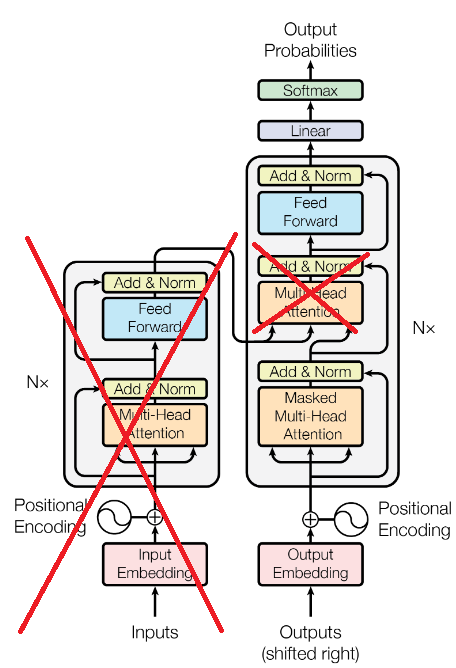

### Elementy składowe dekodera Transformer



**Blok dekodera Transformer** wykorzystywany przez modele klasy GPT składa się z następujących elementów:

1.   Maskowana wielogłowicowa atencja (*masked multi-head attention*), inaczej zwana atencją przyczynową (*causal attention*)
2.   Normalizacja warstwy (*layer norm*)
3.   Blok w pełni połączony (*feed forward*): dwuwarstwowy perceptron
4.   Normalizacja warstwy (*layer norm*)

Dwa dodatkowe połączenia rezydualne poprawiają przepływ gradientu podczas trenowania modelu.

Model językowy zwykle zawiera od kilku do kilkudziesięciu połączonych sekwencyjnie bloków transformatora (oznaczonych na rysunku Nx).


Definicja pomocniczej funkcji wyświetlającej liczbę parametrów modelu.

In [16]:
def print_params_count(model: nn.Module):
  total_params = sum(p.numel() for p in model.parameters())
  total_size_mb = total_params * 4 / (1024 * 1024)
  total_size_bytes = total_params * 4
  trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
  print(f'Number of parameters - Total: {total_params:,d} ({total_size_mb:.1f} MB)   Trainable: {trainable_params:,d}')


#### Warstwa wielogłowicowej atencji (Multi-Head Attention)

Wykorzystamy efektywną implementację **warstwy wielogłowicowej atencji** z biblioteki PyTorch: klasa `MultiheadAttention` ([link](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html#multiheadattention)).
Zadaniem warstwy atencji jest uaktualnienie wektorów cech w sekwencji wejściowej, biorąc pod uwagę **kontekst**.

Zadaniem autoregresyjnego modelu językowego jest **predykcja kolejnego tokenu na podstawie poprzedzającej sekwencji**. Zatem **kontekst** $i$-tego elementu (wektorowej reprezentacji $i$-tego tokenu) nie może zawierać elementów występujących później w sekwencji (na pozycjach $i+1, i+2, \ldots$).
Aby wykluczyć z **kontekstu** elementy następujące później w sekwencji stosujemy maskę atencji.
Metoda `generate_square_subsequent_mask` generuje kwadratową maskę atencji przyczynowej (*causal attention*), która dla każdego elementu sekwencji ogranicza kontekst maskując dostęp do następujących później elementów.

In [17]:
seq_len = 4         # Długośc sekwencji

attn_mask = nn.Transformer.generate_square_subsequent_mask(seq_len)
print(attn_mask)

tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])


Parametry warstwy `MultiheadAttention`:

- `embed_dim` (*embedding dim*) określa rozmiar przetwarzanych wektorów cech. W naszym przypadku równy jest rozmiarowi wektorowych reprezentacji tokenu (768)

- `num_heads` to liczba głowic atencji

-  `batch_first=True` zmienia wymagany format wejściowych tensorów na *(rozmiar wsadu, długość sekwencji, rozmiar wektora cech)*


In [18]:
att = nn.MultiheadAttention(
    embed_dim=MY_GPT_CONFIG["emb_dim"],
    num_heads=MY_GPT_CONFIG["n_heads"],
    dropout=MY_GPT_CONFIG["drop_rate"],
    add_bias_kv=MY_GPT_CONFIG["add_bias_kv"],
    batch_first=True
    )
print(att)
print_params_count(att)

MultiheadAttention(
  (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
)
Number of parameters - Total: 2,362,368 (9.0 MB)   Trainable: 2,362,368


W ogólności na wejściu do warstwy wielogłowicowej atencji możemy podać trzy różne tensory: `query` (zapytanie), `key` (klucz), `value` (wartość), zawierające wektory cech które chcemy auktualnić i wektory cech tworzące kontekst.
W autoregresyjnych modelach językowych **kontekst stanowią poprzedzające elementy z tej samej sekwencji**. Wobec tego wszystkie trzy tensory `query`, `key`, `value` przyjmują tą samą wartość.

Parametr `attn_mask` określa maskę atencji definiującą kontekst brany pod uwagę przy uaktualnianiu kolejnych wektorów cech w sekwencji wejściowej.
Flaga `is_causal=True` mówi, że podana maska atencji jest przyczynowa (*causal mask*) - czyli, że dla danego elementu sekwencji NIE bierze pod uwagę elementów po nim następujących.

In [19]:
batch_size = 2      # Rozmiar wsadu

x = torch.rand(batch_size, seq_len, MY_GPT_CONFIG["emb_dim"])
print(f"Rozmiar wejściowego tensora (x): {x.shape}")

attn_output, attn_output_weights = att(query=x, key=x, value=x,
                                       attn_mask=attn_mask, is_causal=True)

print(f"Rozmiar wyjściowego tensora (attn_output): {attn_output.shape}")
print(f"Rozmiar wyjściowego wektora wag (attn_output_weights): {attn_output_weights.shape}")
print()
print(attn_output_weights)

Rozmiar wejściowego tensora (x): torch.Size([2, 4, 768])
Rozmiar wyjściowego tensora (attn_output): torch.Size([2, 4, 768])
Rozmiar wyjściowego wektora wag (attn_output_weights): torch.Size([2, 4, 4])

tensor([[[1.0185, 0.0000, 0.0000, 0.0000],
         [0.4790, 0.5389, 0.0000, 0.0000],
         [0.2835, 0.3549, 0.3163, 0.0000],
         [0.1616, 0.2667, 0.2413, 0.2723]],

        [[0.9259, 0.0000, 0.0000, 0.0000],
         [0.4396, 0.5782, 0.0000, 0.0000],
         [0.3033, 0.3434, 0.3391, 0.0000],
         [0.2033, 0.2612, 0.2874, 0.2251]]], grad_fn=<MeanBackward1>)


Na wejściu jako `query`, `key` i `value` podajemy ten sam tensor zawierający `batch_size=2` sekwencji złożonych z `seq_len=4` wektorów cech o `emb_dim=768` wymiarach.

Na wyjściu otrzymujemy parę:
- `attn_output` - tensor zawierający uaktualnione wektory cech. Każdy wektor cech jest uaktualniany biorąc pod uwagę **kontekst**, czyli wartości poprzedzających wektorów cech w sekwencji, korzystając z mechanizmu atencji zapytanie-klucz-wartość (query-key-value). **Rozmiar wyjściowego tensora `attn_output` jest identyczny jak wejściowego tensora `x`**.
- `attn_output_weights` - tensor zawierający kwadratowe macierze wag atencji, uśrednione po wszystkich głowicach atencji, dla każdej sekwencji we wsadzie. Zauważmy, że dla $i$-tego elementu w sekwencji, jego wagi atencji względem późniejszych elementów są zerowe (ponieważ zostały one zamaskowane maską atencji).


#### Normalizacja warstwy (*LayerNorm*)

Więcej informacji: [link](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html)

In [20]:
layer_norm = nn.LayerNorm(MY_GPT_CONFIG["emb_dim"])

**Zadanie**

Zaimplementuj następujące kroki:

*   Utwórz losowy tensor zawierający zawierający jedną sekwencję 10 wektorów cech o `MY_GPT_CONFIG["emb_dim"]` wymiarach. Tensor będzie miał rozmiar `(batch_size=1, seq_len=10, MY_GPT_CONFIG["emb_dim"])`.
*   Wyznacz średnią i odchylenie standardowe wartości każdego wektora cech
*   Przetwórz tensor przez warstwę normalizacji `layer_norm` i wyznacz średnią i odchylenie standardowe wartości każdego wektora cech

In [21]:
BATCH_SIZE = 1
SEQ_LEN = 10
random_tensor = torch.rand(BATCH_SIZE, SEQ_LEN , MY_GPT_CONFIG["emb_dim"])

def calculate_mean_and_std_deviation(tensor: Tensor):
    mean = torch.mean(tensor, dim=-1, keepdim=True)
    std = torch.std(tensor, dim=-1, keepdim=True)
    return mean, std

print("Tensor przed normalizacją:")
mean, std = calculate_mean_and_std_deviation(random_tensor)

for i in range(SEQ_LEN):
    print(f"Cecha {i}: {mean[0][i][0]:.2f} +/- {std[0][i][0]:.2f}")

print()
print("Tensor po normalizacji:")
normalized_tensor = layer_norm(random_tensor)
mean, std = calculate_mean_and_std_deviation(normalized_tensor)
for i in range(SEQ_LEN):
    print(f"Cecha {i}: {mean[0][i][0]:.2f} +/- {std[0][i][0]:.2f}")

Tensor przed normalizacją:
Cecha 0: 0.50 +/- 0.29
Cecha 1: 0.49 +/- 0.29
Cecha 2: 0.49 +/- 0.29
Cecha 3: 0.51 +/- 0.29
Cecha 4: 0.50 +/- 0.29
Cecha 5: 0.50 +/- 0.29
Cecha 6: 0.51 +/- 0.29
Cecha 7: 0.50 +/- 0.28
Cecha 8: 0.49 +/- 0.29
Cecha 9: 0.51 +/- 0.29

Tensor po normalizacji:
Cecha 0: 0.00 +/- 1.00
Cecha 1: 0.00 +/- 1.00
Cecha 2: 0.00 +/- 1.00
Cecha 3: -0.00 +/- 1.00
Cecha 4: 0.00 +/- 1.00
Cecha 5: -0.00 +/- 1.00
Cecha 6: 0.00 +/- 1.00
Cecha 7: 0.00 +/- 1.00
Cecha 8: -0.00 +/- 1.00
Cecha 9: -0.00 +/- 1.00


#### Blok w pełni połączony

W architekturze Transformer blok w pełni połączony jest zwykle dwuwarstwowym perceptronem:


*   **Rozmiar wejścia i wyjścia jest równy rozmiarowi wektorowej reprezentacji tokenu** (w naszym modelu `cfg["emb_dim"]=768`)
*   Rozmiar warstwy pośredniej jest wielokrotnością rozmiaru wektorowej reprezentacji tokenu (w naszym modelu `cfg["feedforward_dim_mult"]*cfg["emb_dim"]=3072`)
*   W modelach klasy GPT jako funkcję nieliniową wykorzystano GELU (*Gaussian Error Linear Unit*)



In [22]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], cfg["feedforward_dim_mult"] * cfg["emb_dim"]),
            nn.GELU(),
            nn.Linear(cfg["feedforward_dim_mult"] * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x: Tensor) -> Tensor:
        return self.layers(x)

In [23]:
ff_block = FeedForward(MY_GPT_CONFIG)
print(ff_block)
print_params_count(ff_block)

FeedForward(
  (layers): Sequential(
    (0): Linear(in_features=768, out_features=3072, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=3072, out_features=768, bias=True)
  )
)
Number of parameters - Total: 4,722,432 (18.0 MB)   Trainable: 4,722,432


Zauważmy, że blok w pełni połączony zawiera ponad dwa razy więcej trenowalnych parametrów (4,7 miliona) niż zdefiniowany wcześniej blok wielogłowicowej atencji (2,3 miliona parametrów).

### Blok Transformer

**Blok architektury Transformer** wykorzystywany w modelach klasy GPT złożony jest ze zdefiniowanych wcześniej komponentów:
*   bloku maskowanej wielogłowicowej atencji,
*   bloku w pełni połączonego
*   dwóch normalizacji warstwy (*layer norm*)
*   warstwy odrzutu (*dropout*)

Dodatkowe połączenia rezydualne poprawiają przepływ gradientu podczas trenowania modelu.
Współczesne modele językowe zwykle zawierają od kilkunastu do kilkudziesięciu połączonych sekwencyjnie bloków transformatora cech głębokich.

In [24]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = nn.MultiheadAttention(
            embed_dim=cfg["emb_dim"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            add_bias_kv=cfg["add_bias_kv"],
            batch_first=True)
        self.ff = FeedForward(cfg)
        self.norm1 = nn.LayerNorm(cfg["emb_dim"])
        self.norm2 = nn.LayerNorm(cfg["emb_dim"])
        self.drop = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):

        shortcut = x
        x = self.norm1(x)
        # Blok atencji wielogłowicowej
        seq_len = x.shape[1]
        att_mask = nn.Transformer.generate_square_subsequent_mask(seq_len, device=x.device)
        # Ten sam wektor dla Q, K, V (auto-atencja)
        # MultiheadAttention zwraca parę (attn_output, Optional[attn_output_weights])
        x = self.att(x, x, x, attn_mask=att_mask, need_weights=False, is_causal=True)[0]
        x = self.drop(x)
        x = x + shortcut    # Połączenie rezydualne

        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop(x)
        x = x + shortcut    # Połączenie rezydualne
        return x

In [25]:
transformer_block = TransformerBlock(MY_GPT_CONFIG)
print(transformer_block)
print_params_count(transformer_block)


TransformerBlock(
  (att): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (ff): FeedForward(
    (layers): Sequential(
      (0): Linear(in_features=768, out_features=3072, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=3072, out_features=768, bias=True)
    )
  )
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (drop): Dropout(p=0.1, inplace=False)
)
Number of parameters - Total: 7,087,872 (27.0 MB)   Trainable: 7,087,872


**Zadanie**

Napisz definicję klasy `MyTransformer` implementującą sieć złożoną z $k$ sekwencyjnie połączonych bloków `TransformerBlock`, gdzie $k$ jest parametrem metody `__init__`. Pamiętaj, że klasa implementująca sieć neuronową w PyTorch musi być klasą pochodną klasy `nn.Module`.

Przetwórz losowy tensor o rozmiarach: (wielkość wsadu=2, długość sekwencji=8, rozmiar wektorów cech=768) przez sieć klasy MyTransformer złożoną z $k=4$ bloków.
Wyświetl rozmiar wyjściowego tensora.

In [26]:
class MyTransformer(nn.Module):
    def __init__(self, k, cfg=MY_GPT_CONFIG):
        super().__init__()
        self.blocks = nn.ModuleList([TransformerBlock(cfg) for _ in range(k)])


    def forward(self, x: Tensor) -> Tensor:
        for block in self.blocks:
            x = block(x)
        return x



In [27]:
x = torch.rand(2, 4, 768)
my_transformer = MyTransformer(k=4)
y = my_transformer(x)

print("Rozmiar wejściowego tensora (x):", x.shape)
print("Rozmiar wyjściowego tensora (y):", y.shape)

Rozmiar wejściowego tensora (x): torch.Size([2, 4, 768])
Rozmiar wyjściowego tensora (y): torch.Size([2, 4, 768])


### Model językowy GPT

**Definicja architektury kompletnego modelu z rodzinny GPT**. Model zawiera następujące komponenty:

*   **Słownik wektorowych reprezentacji tokenów** (`self.tok_emb`). Wektorowe reprezentacje tokenów są inicjalizowane losowo i optymalizowane w procesie uczenia sieci.
*   **Słownik kodów pozycyjnych** (`self.pos_emb`). W naszym modelu stosujemy podejście oparte o wyuczone kodowanie pozycyjnie - kody pozycyjne każdej pozycji w sekwencji są inicjalizowane losowo i optymalizowane w procesie uczenia sieci.
*   **Sekwencyjnie połączone bloki Transformer**. W naszym modelu mamy `cfg["n_layers"]=12` bloków.
*   **Głowicę klasyfikacyjną** zwracającą rozkład prawdopodobieństwa kolejnego tokenu w sekwencji. Liczba klas jest równa rozmiarowi słownika (51200 w nazym modelu).




Słowniki wektorowych reprezentacji tokenów i kodów pozycyjnych są zaimplementowane jako warstwa `torch.nn.Embedding` [link](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html).

In [28]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.context_length = cfg["context_length"]
        self.emb_dim = cfg["emb_dim"]
        self.vocab_size = cfg["vocab_size"]

        self.tok_emb = nn.Embedding(self.vocab_size, self.emb_dim)
        self.pos_emb = nn.Embedding(self.context_length, self.emb_dim)
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
            )

        self.final_norm = nn.LayerNorm(self.emb_dim)
        self.out_head = nn.Linear(self.emb_dim, self.vocab_size, bias=False)

    def forward(self, token_ids: Tensor) -> Tensor:
        batch_size, seq_len = token_ids.shape
        assert seq_len <= self.context_length

        tok_embeds = self.tok_emb(token_ids)

        pos_embeds = self.pos_emb(torch.arange(seq_len, device=token_ids.device))
        # Sumowanie wektorowych reprezentacji tokenów i wektorów kodujących pozycje
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        # Klasyfkator liniowy - predykcja kolejnego tokenu w sekwencji
        logits = self.out_head(x)
        return logits


In [29]:
torch.manual_seed(123)
print(MY_GPT_CONFIG)
model = GPTModel(MY_GPT_CONFIG)
print(model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
model.to(device)

{'vocab_size': 51200, 'context_length': 256, 'emb_dim': 768, 'n_heads': 12, 'n_layers': 12, 'feedforward_dim_mult': 4, 'add_bias_kv': False, 'drop_rate': 0.1}
GPTModel(
  (tok_emb): Embedding(51200, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (drop): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiheadAttention(
        (out_proj): NonDyn

GPTModel(
  (tok_emb): Embedding(51200, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (drop): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in

In [30]:
print_params_count(model)

Number of parameters - Total: 163,895,808 (625.2 MB)   Trainable: 163,895,808


In [31]:
print(model.tok_emb.weight.dtype)

torch.float32


In [32]:
texts = ["Ala ma kota", "W sławnym mieście Pacanowie"]
encoded_inputs = tokenizer(texts, return_tensors='pt', padding=True)
input_ids = encoded_inputs['input_ids']

input_ids = input_ids.to(device)
print(input_ids.shape)

out = model(input_ids)

print(f"Input shape: {input_ids.shape}")
print(f"Input: {input_ids}")
print()
print(f"Output shape: {out.shape}")
print(f"Output: {out}")

torch.Size([2, 7])
Input shape: torch.Size([2, 7])
Input: tensor([[   37,   352,   438, 14331,     2,     2,     2],
        [   59,  2285, 18209,  3788,  1058, 11151,   392]], device='cuda:0')

Output shape: torch.Size([2, 7, 51200])
Output: tensor([[[ 0.1617, -0.1444, -0.5058,  ..., -0.5193, -0.9829, -0.2560],
         [ 0.6906,  0.2345, -0.2861,  ...,  0.5529, -1.2172,  0.0500],
         [-0.8030,  0.3770, -0.4870,  ...,  0.1096,  0.3802,  0.7226],
         ...,
         [ 0.3922, -0.0869, -0.6238,  ...,  0.0940, -0.7077,  0.8932],
         [ 0.5355, -0.5299, -0.1898,  ..., -0.3136, -0.0138,  0.7965],
         [-1.1042, -0.3610, -0.1046,  ..., -0.3859, -0.0159,  0.5791]],

        [[ 1.3081, -0.0989, -0.7491,  ...,  0.4450, -1.2453, -0.2782],
         [-0.2928,  1.3171, -0.4554,  ...,  0.3180, -0.5646,  0.2564],
         [-0.8232,  0.3178, -1.2134,  ...,  0.7586,  1.0882,  0.0373],
         ...,
         [ 1.3945,  0.0131, -0.1186,  ...,  0.6314, -0.3780, -1.5411],
         [ 0.7104

Wejściowy tensor `input_ids` ma wymiary (rozmiar wsadu = 2, długość sekwencji = 7).

Wyjściowy tensor `out` ma wymiary (rozmiar wsadu = 2, długość sekwencji = 7, rozmiar słownika = 51200) i zawiera rozkład prawdopodobieństwa (a dokładnie nieznormalizowane logarytmy prawdopodobieństwa zwane *logitami*) tokenów na kolejnych pozycjach w sekwencji warunkowane poprzedzającymi tokenami. Np. `out[0, 3]` jest 51200-elementowym wektorem zawierającym rozkład prawdopodobieństwa kolejnego tokenu warunkowany tokenami na pozycjach $0\ldots3$ w sekwencji wejściowej 0.

**Zadanie**

Wyświetl kolejne najbardziej prawdopodobne tokeny następujące po sekwencji 1. Czyli kolejne tokeny odpowiadające największej wartości `out[1, i]` dla $0 \leq i <7$. Zdekoduj (zamień na tekst) numeryczne identyfikatory tokenów.

In [33]:
print(f'Sekwencja 1: {texts[1]}')

for i in range(7):
    predictions = out[1, i]

    predicted_token_id = predictions.argmax().item()
    predicted_token = tokenizer.decode(predicted_token_id)

    print(f"Token {i}:  {predicted_token}: {predicted_token_id}")

Sekwencja 1: W sławnym mieście Pacanowie
Token 0:  sie: 588
Token 1:   wymagające: 35574
Token 2:   racjonal: 10552
Token 3:   zmierz: 17612
Token 4:   sprawiedliwości: 6628
Token 5:   uga: 37480
Token 6:   zbroję: 49088


Wygenerowane tokeny nie będą sensowną kontynuacją podanego promptu. I nic dziwnego, model został zainicjalizowany z losowymi wagami i nie został wytrenowany.

## Trenowanie modelu (*pretraining*)

### Zbiór treningowy

Do wytrenowania naszego modelu wykorzystamy zbiór danych *wolne lektury* będący częścią publicznie dostępnego polskiego korpusu językowego
[SpeakLeash a.k.a Spichlerz](https://speakleash.org/o-nas/).
Wielkość korpusu językowego zgromadzonego w ramach projektu można sprawdzić [tutaj](https://speakleash.org/dashboard/).

In [34]:
#Download a file from a Google Drive
!gdown 1aQ1AK9X07saOCIjmirAlcRbJPQnjv7GG

Downloading...
From (original): https://drive.google.com/uc?id=1aQ1AK9X07saOCIjmirAlcRbJPQnjv7GG
From (redirected): https://drive.google.com/uc?id=1aQ1AK9X07saOCIjmirAlcRbJPQnjv7GG&confirm=t&uuid=600abdde-e9f5-4e34-b710-20fe3fc8320d
To: /content/wolne_lektury_dataset_dump.pkl
100% 284M/284M [00:03<00:00, 84.4MB/s]


In [35]:
with open('wolne_lektury_dataset_dump.pkl', 'rb') as f:
    dataset_dump = pickle.load(f)

In [36]:
from typing import no_type_check_decorator

def print_dataset_stats(ds):
  print(f"Liczba dokumentów w zbiorze danych: {len(ds):,}")
  n_char = 0
  for doc in ds:
    n_char += len(doc)
  print(f"Liczba znaków w zbiorze danych: {n_char:,}")
  print(f"Średnia długość dokumentu: {n_char/len(ds):.1f}")
  print(f"Maksymalna długość dokumentu: {max([len(doc) for doc in ds]):,}")
  print(f"Minimalna długość dokumentu: {min([len(doc) for doc in ds]):,}")

In [37]:
print_dataset_stats(dataset_dump)

Liczba dokumentów w zbiorze danych: 6,619
Liczba znaków w zbiorze danych: 262,196,111
Średnia długość dokumentu: 39612.6
Maksymalna długość dokumentu: 2,438,186
Minimalna długość dokumentu: 35


Pomocnicza funkcja tokenizująca zbiór danych i dzieląca dokumenty na kawałki (*chunks*) równej długości.

In [38]:
from transformers import BatchEncoding

def tokenize_and_split(text: str, context_length: int) -> BatchEncoding:
  outputs = tokenizer(
      text,
      truncation=True,
      max_length=context_length,
      return_overflowing_tokens=True,
      stride=context_length // 2,       # The number of overlapping tokens between chunks
      return_tensors = 'pt'
    )
  return outputs

Definicja klasy GPTDataset udostępniającej zbiór danych do trenowania autoregresyjnego modelu językowego.
Każdy z dokumentów w zbiorze danych jest dzielony na równej długości kawałki (*chunks*), które są następnie tokenizowane. Parametr krok (*stride*) określa odstęp między początkami kolejnych kawałków. Jeśli krok (`stride`) jest mniejszy od rozmiaru kawałka (`chunk_size`), to kolejne kawałki będą wycinane na zakładkę i będą na siebie nachodziły.

In [39]:
from torch.utils.data import Dataset
from tqdm.notebook import trange, tqdm

class GPTDataset(Dataset):
    def __init__(self, dataset_dump: list[str], tokenizer, chunk_size: int, stride: int):
        #dataset_dump: lista dokumentów, gdzie każdy dokument jest pojedynczym łańcuchem tekstowym
        self.chunk_size = chunk_size
        self.stride = stride

        self.tokens = []

        count_skipped = 0
        self.total_chunks = 0
        doc_idx = 0

        # Indeks global_idx -> (doc_idx, chunk_idx)
        self.idx_to_doc_chunk = {}

        # Iteracja po kolejnych dokumentach w zbiorze danych
        for text in tqdm(dataset_dump):
            tokenized_text = tokenizer(text, return_tensors='pt', padding=True)
            tokenized_doc = tokenized_text['input_ids'][0]
            num_chunks_per_doc = (len(tokenized_doc) - chunk_size) // stride

            self.tokens.append(tokenized_doc)
            # Wygeneruj globalne indeksy dla każdego kawałka (chunk) w przetwarzanym dokumencie
            temp = {self.total_chunks + chunk_idx: (doc_idx, chunk_idx) for chunk_idx in range(num_chunks_per_doc)}
            # Dodaj wygenerowane indeksy do słownika self.idx_to_doc_chunk
            self.idx_to_doc_chunk.update(temp)

            self.total_chunks += num_chunks_per_doc
            doc_idx += 1

        assert doc_idx == len(self.tokens)

    def __len__(self) -> int:
        return self.total_chunks

    def __getitem__(self, idx) -> dict[str, Tensor]:
        # idx: globalny indeks kawałka tekstu
        doc_idx, chunk_idx = self.idx_to_doc_chunk[idx]
        start_idx = chunk_idx*self.stride
        item = {
            # input_ids: identyfikatory tokenów w sekwencji treningowej
            'input_ids': self.tokens[doc_idx][start_idx: start_idx + self.chunk_size],
            # labels: Identyfikatory tokenów docelowych = sekwencja treningowa przesunięta o jedną pozycję w prawo
            'labels': self.tokens[doc_idx][start_idx + 1: start_idx + self.chunk_size + 1]
            }
        return item


Inicjalizacja zbioru danych treningowych i walidacyjnych.

In [40]:
# Ten kod wykonuje się około 2 minut

train_dataset = GPTDataset(dataset_dump[:2000], tokenizer, MY_GPT_CONFIG["context_length"], 1)
val_dataset = GPTDataset(dataset_dump[-10:], tokenizer, MY_GPT_CONFIG["context_length"], 1)

# Run garbage collection
del dataset_dump
import gc
gc.collect()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

66

In [41]:
print(f"Liczba elementów w zbiorze danych: {len(train_dataset)}")

ndx = 32132
print(f"Element o indeksie: {ndx}")
e = train_dataset[ndx]
for key in e:
    print()
    print(f"Klucz {key}: Rozmiar tensora {e[key].shape}")
    print(f"Pierwszych 10 elementów: {e[key][:10]}")
    for i in range(10):
        print(tokenizer.decode(e[key][i]))


Liczba elementów w zbiorze danych: 15961850
Element o indeksie: 32132

Klucz input_ids: Rozmiar tensora torch.Size([256])
Pierwszych 10 elementów: tensor([ 8739, 28330, 28550,   639,  1505,  7665,  2147, 21782,  1188,   363])
 wypu
kłym
 den
kiem
 poprze
bij
anym
 dziur
kami
 jak

Klucz labels: Rozmiar tensora torch.Size([256])
Pierwszych 10 elementów: tensor([28330, 28550,   639,  1505,  7665,  2147, 21782,  1188,   363,   264])
kłym
 den
kiem
 poprze
bij
anym
 dziur
kami
 jak
 w


Element zbioru danych jest słownikiem o polach:
- `input_ids`: identyfikatory tensorów w sekwencji wejściowej
- `labels`: identyfikatory tensorów docelowych (etykiety)

Możemy zauważyć, że sekwencja docelowa (`labels`) powstała przez przesunięcie sekwencji wejściowej o jedną pozycję w prawo. Celem jest predykcja kolejnego tokenu na podstawie poprzedzających tokenów w sekwencji.


Utworzenie obiektów klasy `DataLoader` dla zbioru treningowego i walidacyjnego.

In [42]:
from torch.utils.data import DataLoader

num_workers = 1
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)


Wyświetl zawartość przykładowego wsadu.

In [43]:
batch = next(iter(train_loader))
print(batch)

for k, v in batch.items():
    print(f"{k}: {v.shape}")


{'input_ids': tensor([[  304,   438,   681,  ...,  1520,   575,     5],
        [   16,  1147,  4759,  ..., 14255,  1164, 30366],
        [13863, 34679,    18,  ...,   407,  9325,  1914],
        ...,
        [ 2239,    18, 10892,  ..., 18977,   587,    18],
        [  309,  5842,   541,  ...,   648,   704,   282],
        [25154,    16,  1794,  ..., 13764,  1412,  1011]]), 'labels': tensor([[  438,   681,  8813,  ...,   575,     5, 13478],
        [ 1147,  4759,   304,  ...,  1164, 30366,   268],
        [34679,    18,  4725,  ...,  9325,  1914, 15573],
        ...,
        [   18, 10892, 27734,  ...,   587,    18,   203],
        [ 5842,   541,    18,  ...,   704,   282,   613],
        [   16,  1794,  6023,  ...,  1412,  1011,   306]])}
input_ids: torch.Size([16, 256])
labels: torch.Size([16, 256])


### Inicjalizacja modelu

Inicjalizacja modelu językowego klasy GPT.

In [44]:
model = GPTModel(MY_GPT_CONFIG)
model.to(device)

print_params_count(model)

Number of parameters - Total: 163,895,808 (625.2 MB)   Trainable: 163,895,808


**Zadanie**

Przetwórz sekwencje identyfikatorów tokenów ze wsadu `batch['input_ids']` przez `model`.
Wyświetl rozmiar wejściowego tensora `batch['input_ids']` i wyjściowego tensora z modelu. Napisz jak interpretujesz wymiary wyjściowego tensora.

In [50]:
input_ids = batch["input_ids"].to(device)
print(f"Input size : {input_ids.shape}")

out_batch = model(input_ids)
print(f"Output size : {out_batch.shape}")

Input size : torch.Size([16, 256])
Output size : torch.Size([16, 256, 51200])


Interpretacja wyników :
- Wyjściowy tensor ma kształt [16, 256, 512000], co odpowiada: batch_size, sequence_length, vocab_size.

- Oznacza to, że dla każdego tokena w każdej sekwencji model przewiduje rozkład logitów nad całym słownikiem (512k tokenów).

- Logity te reprezentują "nieprzetworzone" prawdopodobieństwa kolejnych tokenów w sekwencji. Dla każdej pozycji i model uwzględnia kontekst tokenów od pozycji 0 do i-1

### Funkcje pomocnicze

Przeniesienie wsadu na urządzenie `device`.

In [51]:
def batch_to_device(batch: dict, device) -> dict:
    return {k: v.to(device) for k, v in batch.items()}

W treningu wielkich modeli językowych korzystamy z **funkcji straty entropii krzyżowej** między predykowanym przez sieć rozkładem prawdopodobieństwa kolejnego tokenu w sekwencji a docelowym rozkładem prawdopodobieństwa (jedynka na pozycji odpowiadającej kolejnemu tokenowi w sekwencji treningowej, zera na pozostałych pozycjach).   

In [52]:
def calc_loss_batch(batch: dict, model: nn.Module) -> Tensor:
    logits = model(batch['input_ids'])
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), batch['labels'].flatten())
    return loss

Pomocnicza funkcja wyznaczająca wartość funkcji straty dla `num_batches` wsadów z data loadera.

In [53]:
def calc_loss_loader(data_loader, model, device, num_batches: int) -> float:
    total_loss = 0.
    for i, batch in enumerate(data_loader):
        if i >= num_batches:
            break
        batch = batch_to_device(batch, device)
        loss = calc_loss_batch(batch, model)
        total_loss += loss.item()

    return total_loss / num_batches

Pomocnicza funkcja do ewaluacji modelu na zbiorze treningowym i walidacyjnym.

In [54]:
def evaluate_model(model: nn.Module, train_loader: DataLoader,
                   val_loader: DataLoader, device, eval_iter: int) -> tuple[float, float]:
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)

    return train_loss, val_loss

Funckja pomocnicza znajdująca $k$ najbardziej prawdopodobnych tokenów następujących po danej sekwencji wejściowej.

In [55]:
def topk_tokens(model: nn.Module, context: str, k: int) -> dict[str, float]:
    # Funkcja zwaraca słownik k najbardziej prawdopodobnych tokentów {token: prawdopodobieństwo}
    token_ids = tokenizer(context, return_tensors='pt')['input_ids'].to(device)
    model.eval()
    with torch.no_grad():
        logits = model(token_ids)
        # logits jest tensorem (rozmiar wsadu=1, długość sekwencji, rozmiar słownika)

    # Weź rozkład prawdopodobieństwa (logit'y) ostatniego elementu w zerowej sekwencji
    logits = logits[0, -1, :]
    # logits jest tensorem (rozmiar słownika,)

    probas = torch.softmax(logits, dim=-1)
    top_probas, top_pos = torch.topk(probas, k)
    results = {tokenizer.decode(ndx): pp.item() for (ndx, pp) in zip(top_pos, top_probas)}
    return results


### Pętla treningowa

Implementacja pętli treningowej modelu.

In [56]:
import numpy as np

def train_model(model: nn.Module, train_loader: DataLoader,
                val_loader: DataLoader, optimizer, lr_scheduler,
                device, num_epochs: int, eval_freq: int, eval_iter: int,
                start_context: str, tokenizer, max_steps: int = None):

    tokens_seen, global_step = 0, 0

    for epoch in range(num_epochs):
        for batch in train_loader:
            model.train()
            batch = batch_to_device(batch, device)
            optimizer.zero_grad()
            loss = calc_loss_batch(batch, model)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.)

            optimizer.step()
            lr_scheduler.step()

            tokens_seen += batch['input_ids'].numel()
            global_step += 1

            if global_step % eval_freq == 0:
                # Ewaluacja modelu
                train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
                print(f"Epoch: {epoch+1} (Step: {global_step:06d}  Tokens seen: {tokens_seen // 1000:06d}k): "
                      f"Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f} "
                      f"Train perplexity: {np.exp(train_loss):.3f}, Val perplexity: {np.exp(val_loss):.3f} ")

                predictions = topk_tokens(model, start_context, k=8)
                print(f"       {start_context} _: ", end=' ')
                for token, prob in predictions.items():
                    print(f"{token} ({prob:.3f})", end=' ')
                print()

            if max_steps is not None and global_step >= max_steps:
                return

Uruchomienie treningu modelu. Liczba iteracji treningowych została ograniczona do 500 co pozwala na przetworzenie około 2 milionów tokenów ze zbioru treningowego. Trening na T4 GPU trwa około 10 minut.

In [57]:
import time

num_epochs = 1
#max_steps = 500
max_steps = 500

optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4, weight_decay=0.1)
t_max = len(train_loader) * num_epochs
print(f"Liczba iteracji: {t_max}")
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, t_max, eta_min=1e-5)

start_context = "Pies wszedł do"

start = time.time()
train_model(model, train_loader, val_loader, optimizer, lr_scheduler, device,
            num_epochs=num_epochs, eval_freq=50, eval_iter=10,
            start_context=start_context, tokenizer=tokenizer, max_steps=max_steps)
end = time.time()
print(f"Czas wykonania: {(end - start)/60:0.1f} [m]")


Liczba iteracji: 997616
Epoch: 1 (Step: 000050  Tokens seen: 000204k): Train loss: 7.608, Val loss: 7.431 Train perplexity: 2013.620, Val perplexity: 1686.742 
       Pies wszedł do _:  , (0.025) . (0.015)  do (0.008)  i (0.008)  z (0.007)  to (0.007)  na (0.007)  się (0.007) 
Epoch: 1 (Step: 000100  Tokens seen: 000409k): Train loss: 7.432, Val loss: 7.250 Train perplexity: 1688.858, Val perplexity: 1408.733 
       Pies wszedł do _:   tym (0.011)  tego (0.009)  nią (0.007)  nich (0.007)  siebie (0.007)  mnie (0.006)  niej (0.005)  domu (0.005) 
Epoch: 1 (Step: 000150  Tokens seen: 000614k): Train loss: 7.355, Val loss: 7.123 Train perplexity: 1564.337, Val perplexity: 1239.806 
       Pies wszedł do _:   tego (0.021)  niej (0.016)  siebie (0.013)  niego (0.008)  domu (0.008)  mnie (0.007)  sobą (0.007)  czasu (0.007) 
Epoch: 1 (Step: 000200  Tokens seen: 000819k): Train loss: 7.167, Val loss: 7.069 Train perplexity: 1296.188, Val perplexity: 1175.272 
       Pies wszedł do _:   siebi

In [58]:
# Wyświetl 10 najbardziej prawdopodobnych tokenów dla podanego promptu
predictions = topk_tokens(model, "W pewien piękny wiosenny dzień Tadeusz", k=10)
for token, prob in predictions.items():
    print(f"{token}: {prob:.3f}")

,: 0.178
.: 0.057
 i: 0.038
 w: 0.015
 się: 0.015
 na: 0.011
 z: 0.011
;: 0.010
 do: 0.008
 nie: 0.007


## Pobranie wag wytrenowanego modelu

Znacznie lepsze rezultaty osiągniemy wykorzystując model trenowany przez dłuższy czas.
Tutaj pobierzemy wagi modelu trenowanego przez 3 dni na naszynie z 6 GPU nVidia RTX 4090 (łącznie około 432 godziny GPU). Korpus treningowy zawierał zbiory danych: wolne_lektury_corpus, 1000_novels_corpus_CLARIN-PL, open_subtitles_corpus i plwiki. Dla porównania model Lllama 2 wersja 7B potrzebował 184 tysięcy godzin GPU (A100-80GB).

Pretrenowany model ma identyczną konfigurację jak wcześniejszy model, za wyjątkiem większego okna kontekstu (512 zamiast 256 tokenów).


In [59]:
MY_GPT_CONFIG2 = {
    "vocab_size": tokenizer.vocab_size, # Vocabulary size
    "context_length": 512,              # Context length
    "emb_dim": 768,                     # Embedding dimension
    "n_heads": 12,                      # Number of attention heads
    "n_layers": 12,                     # Number of layers
    "feedforward_dim_mult": 4,          # Feedforward dimension multiplier
    "add_bias_kv": False,               # Add bias to the key and value projections
    "drop_rate": 0.1                    # Dropout rate
}

In [60]:
!gdown 1yij01sTy5_9SA4Yge4ai7QNi9pKmSuug

Downloading...
From (original): https://drive.google.com/uc?id=1yij01sTy5_9SA4Yge4ai7QNi9pKmSuug
From (redirected): https://drive.google.com/uc?id=1yij01sTy5_9SA4Yge4ai7QNi9pKmSuug&confirm=t&uuid=3723674d-6ee0-4cda-b3f7-4f734529ee75
To: /content/my_gpt_20240808_211159_400000.ckpt
100% 1.97G/1.97G [00:43<00:00, 45.1MB/s]


In [61]:
import torch
path = "my_gpt_20240808_211159_400000.ckpt"

weights = torch.load(path)['model']

In [62]:
model = GPTModel(MY_GPT_CONFIG2)
model.to(device)
model.load_state_dict(weights)


<All keys matched successfully>

In [63]:
predictions = topk_tokens(model, "Pies wszedł do", k=10)
for ndx, (token, prob) in enumerate(predictions.items()):
    print(f"{ndx} - {token}: {prob:.3f}")

0 -  pokoju: 0.227
1 -  środka: 0.059
2 -  domu: 0.051
3 -  mojego: 0.032
4 -  kuchni: 0.025
5 -  baru: 0.023
6 -  budynku: 0.021
7 -  biura: 0.019
8 -  sklepu: 0.018
9 -  jej: 0.018


In [64]:
predictions = topk_tokens(model, "W pewien piękny wiosenny dzień Tadeusz", k=10)
for token, prob in predictions.items():
    print(f"{token}: {prob:.3f}")

 i: 0.051
,: 0.046
 był: 0.014
owi: 0.014
 nie: 0.012
 ujrzał: 0.010
 wracał: 0.010
 przy: 0.009
 spotkał: 0.009
 wrócił: 0.008


**Zadanie**
Wykorzystaj funkcję `evaluate_model()` aby wyznaczyć wartość funkcji straty na zbiorze treningowym (`train_loader`) i walidacyjnym (`val_loader`) pobranego modelu. Liczbę iteracji (`eval_iter`) ogranicz do 50.

Korzystając z wyznaczonych wartości funkcji straty oblicz metrykę *perplexity* dla danych treningowych i walidacyjnych ($pp=e^{loss}$).

In [66]:
train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter=50)

print(f"Train loss : {train_loss:.4f}, Val loss : {val_loss:.4f}")

train_loss_pp = np.exp(train_loss)
val_loss_pp = np.exp(val_loss)

print(f"Train perplexity : {train_loss_pp}, Val perplexity {val_loss_pp}")

Train loss : 3.5962, Val loss : 3.8631
Train perplexity : 36.461118026856404, Val perplexity 47.613124999784766


## Strategie generowania tekstu

Autoregresyjny model językowy zwraca **rozkład prawdopodobieństwa** (a dokładniej nieznormalizowane logarytmy prawdopodobieństwa zwane logitami) **kolejnego tokenu dla każdej pozycji w sekwencji wejściowej**.
```
# token_ids: wejściowy tensor o rozmiarach (rozmiar wsadu, długość sekwencji)
logits = model(token_ids)
# logits: tensor (rozmiar wsadu, długość sekwencji, wielkość słownika)
```
Generując kolejny token interesuje nas tylko rozkład prawdopodobieństwa elementu następującego **po ostatnim** tokenie sekwencji wejściowej. Czyli ze zwróconego przez model tensora wybieramy tylko elementy z indeksem -1 w drugim wymiarze.
```
logits = logits[:, -1, :]
```

W bibliotece HuggingFace zaimplementowane są typowe strategie generowania tekstu.
Do celów edukacyjnych w notatniku zaimplementowano własną funkcję generowania tekstu `generate_text` parametryzowaną funkcją definiującą **strategię samplowania** `sampling_fn`.


In [67]:
def generate_text(model: nn.Module, tokenizer, sampling_fn, device,
                  start_context: str, max_new_tokens: int = 20) -> str:
    # sampling_fn: funkcja samplująca
    model.eval()
    context_size = model.context_length
    token_ids = tokenizer(start_context, return_tensors='pt')['input_ids'].to(device)

    with torch.no_grad():
        for _ in range(max_new_tokens):
            # Ogranicz długość sekwencji do okna kontekstu modelu
            logits = model(token_ids[:, -context_size:])
            # logits jest tensorem (rozmiar wsadu=1, długość sekwencji, rozmiar słownika)

            # Weź rozkład prawdopodobieństwa (logit'y) ostatniego elementu w sekwencji
            logits = logits[:, -1, :]

            # Samplowanie kolejnego tokenu
            next_token_id = sampling_fn(logits)
            batch_size = logits.shape[0]
            assert next_token_id.shape == (batch_size, 1)

            # Dołącz token do uprzednio wygenerowanej sekwencji
            token_ids = torch.cat((token_ids, next_token_id), dim=1)

    decoded_text = tokenizer.decode(token_ids.squeeze(0))
    return decoded_text

W **strategii zachłannej** (funkcja `greedy_sampling_fn`) wybieramy deterministycznie token o największym prawdopodobieństwie.

In [68]:
def greedy_sampling_fn(logits: Tensor) -> Tensor:
    # logits: tensor o wymiarach (rozmiar wsadu, wielkość słownika)

    # Dla każdego elementu wsadu zwróć id najbardziej prawdopodobnego tokenu
    return torch.argmax(logits, dim=-1, keepdim=True)

In [69]:
start_context = "Natalia weszła do pokoju i ze zdumieniem zobaczyła w lustrze dziwną"

decoded_text = generate_text(model, tokenizer, greedy_sampling_fn, device,
                             start_context, max_new_tokens=50)
print(decoded_text)

Natalia weszła do pokoju i ze zdumieniem zobaczyła w lustrze dziwną postać.

— To jest pan, panie hrabio? — zawołała. — Czy pan jest hrabią?

— Tak, jestem hrabią.

— Ach, to pan! — zawołała. — Ach, to pan!



**Wybór losowy** tokenu zgodnie z rozkładem prawdopodobieństwa wyznaczonym przez model.
Funkcja `softmax` zamienia zwrócone przez model nieznormalizowane logarytmy prawdopodobieństwa (logity) na rozkład prawdopodobieńśtwa klas.

In [70]:
def probabilistic_sampling_fn(logits: Tensor) -> Tensor:
  probas = torch.softmax(logits, dim=-1)
  token_id = torch.multinomial(probas, num_samples=1)
  return token_id

In [71]:
generated_text = generate_text(model, tokenizer, probabilistic_sampling_fn, device, start_context, max_new_tokens=100)
print(generated_text)

Natalia weszła do pokoju i ze zdumieniem zobaczyła w lustrze dziwną sylwetkę ludzką, nieznaną jejJuż przedtem, od tej nocy, owej gdzie? przed jej pięknem tatą? Domyśliła się, pod kogo ta osoba czynienia ma. Mościa majorowa odgadła natychmiast. Poskoczył tedy ku niej z nieokreśloną radością. Kucharka skinęła głową. Młodzieniec błyskawicznie barakudjit zapytał ze zwykłą ceremonią, jaki to jest szpital? Nie wiedział, wprowadzony został na salę, dokąd go zaprowadzono. Kapitan spojrzał na Furkatja i pokiwała głową


**Skalowanie temperatury** (*temperature scaling*) pozwala zmodyfikować rozkład prawdopodobieństwa kolejnego tokenu poprzez zastosowanie funkcji **softmax z temperaturą** danej wzorem:
$$
\sigma(z_i) = \frac{e^{z_i / \tau}}{\sum_{j} e^{z_j / \tau}} \, ,
$$ gdzie $z_i$ to wartość $i$-tego logit'a, $\tau > 0$ jest parametrem temperatury.

$\tau < 1$ 'wyostrza' rozkład prawdopodobieństwa - zwiększa prawdopodobieństwa najbardziej prawdopodobnych klas i tłumi klasy rzadkie.
Dla $\tau > 1$ różnice między prawdopodobieństwami  klas zmniejszają się. Dla $\tau \to \infty $ rozkład dąży do równomiernego.

**Zadanie**

Zaimplementuj funkcję `softmax_with_temperature` daną powyższym wzorem.

In [72]:
# Przykładowe rozwiązanie
def softmax_with_temperature(logits: Tensor, temperature: float) -> Tensor:
    token_id = torch.softmax(logits/temperature, dim=-1)

    return token_id

Sprawdzenie funkcji `softmax_with__temperature`

In [75]:
start_context = "W pewien upalny sierpniowy dzień Tadeusz"
token_ids = tokenizer(start_context, return_tensors='pt')['input_ids'].to(device)

model.eval()
with torch.no_grad():
    logits = model(token_ids)
    logits = logits[0, -1, :]

print(logits.shape)
print()
print(f"Kontekst: {start_context}")

# Klasyczny SOFTMAX
probas = torch.softmax(logits, dim=-1)
k = 5
top_probas, top_pos = torch.topk(probas, k)
print(f"SOFTMAX - {k} najbardziej prawdopodobnych klas")
for i in range(k):
    print(f"token: {top_pos[i]} ({tokenizer.decode(top_pos[i])})  pp: {top_probas[i]:0.5f}")


# SOFTMAX WITH TEMPERATURE
tau = 0.4
probas = softmax_with_temperature(logits, temperature=tau)

assert probas.shape == logits.shape
assert torch.allclose(torch.sum(probas, dim=-1), torch.tensor(1.))

top_probas, top_pos = torch.topk(probas, k)
print()
print(f"SOFTMAX WITH TEMPERATURE={tau} - {k} najbardziej prawdopodobnych klas")
for i in range(k):
    print(f"token: {top_pos[i]} ({tokenizer.decode(top_pos[i])})  pp: {top_probas[i]:0.5f}")


torch.Size([51200])

Kontekst: W pewien upalny sierpniowy dzień Tadeusz
SOFTMAX - 5 najbardziej prawdopodobnych klas
token: 292 ( i)  pp: 0.03180
token: 16 (,)  pp: 0.02283
token: 630 ( był)  pp: 0.02169
token: 406 (owi)  pp: 0.01408
token: 304 ( nie)  pp: 0.01145

SOFTMAX WITH TEMPERATURE=0.4 - 5 najbardziej prawdopodobnych klas
token: 292 ( i)  pp: 0.37457
token: 16 (,)  pp: 0.16351
token: 630 ( był)  pp: 0.14386
token: 406 (owi)  pp: 0.04885
token: 304 ( nie)  pp: 0.02911


**Samplowanie top-k** (*top-k sampling*) wybiera losowo z $k$ najbardziej prawdopodobnych tokenów zgodnie z rozkładem prawdopodobieństwa zwróconym przez model.

In [76]:
def topk_sampling_fn(logits: Tensor) -> Tensor:
  top_k = 3
  # Assume batch size = 1
  assert logits.shape[0] == 1
  logits = logits.squeeze(0)
  top_logits, top_pos = torch.topk(logits, top_k)
  new_logits = torch.where(logits < top_logits[-1], torch.tensor(float('-inf')), logits)
  probas = torch.softmax(new_logits, dim=-1)
  token_id = torch.multinomial(probas, num_samples=1)
  return token_id.unsqueeze(0)

In [77]:
generated_text = generate_text(model, tokenizer, topk_sampling_fn, device, start_context, max_new_tokens=100)
print(generated_text)

W pewien upalny sierpniowy dzień Tadeusz i Marysia byli w domu.





— Czy pan nie wie, że pani nie jest w domu? — zapytał pan Kazimierz, gdy się drzwi otworzyły.

— Nie, nie wiem — odparła Marysia, nie mogąc się powstrzymać.

Pan Kazimierz stał na środku pokoju i patrzył na Marysię.

— Czy pani jest w domu?

— Jestem — odpowiedziała pani. — Czy pan nie wie?

— Nie, ale… — odparł pan


# Wykorzystanie wstępnie wytrenowanego polskiego modelu językowego Qra-1b

**Rodzina polskich modeli językowych Qra** (1B, 7B, 13B) oparta jest o architekturę modeli językowych Llama. Modele zostały zainicjalizowane publicznie dostępnymi wagami modeli Llama 2 a następnie dotrenowane na polskich zasobach językowych (90 miliardów tokenów).
Modele z rodziny Qra są statystycznymi modelami języka. Nie są przeznaczone do bezpośredniego wykorzystania w systemach dialogowych lub do wykonywania poleceń. Muszą zostać dotrenowane aby mogły być wykorzystane do takich celów.
Więcej informacji: [link](https://huggingface.co/OPI-PG/Qra-1b).

In [78]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "OPI-PG/Qra-1b"

tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side="left")
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True
    )
model.eval()

tokenizer_config.json:   0%|          | 0.00/935 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/437 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/752 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 2048)
    (layers): ModuleList(
      (0-21): 22 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=5632, bias=False)
          (up_proj): Linear(in_features=2048, out_features=5632, bias=False)
          (down_proj): Linear(in_features=5632, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((2048,), eps=1e-05)
    (rotary_emb): 

In [79]:
print_params_count(model)

Number of parameters - Total: 1,100,048,384 (4196.4 MB)   Trainable: 1,100,048,384


Modele z biblioteki HuggingFace posiadają metodę `generate` pozwalającą generować tekst z różnymi strategiami samplowania. Oprócz podstawowych strategii zaimplementowane są bardziej złożone metody poprawiające jakość generowanego tekstu takie, jak **przeszukiwania wiązki** (*beam search*). Więcej informacji na temat metod generowania tekstu [link](https://huggingface.co/blog/how-to-generate).

**Zadanie**
Wykorzystaj metodę generate modelu językowego `model.generate(...)` aby wygenerować kontynuację podanego promptu korzystając z następujących strategii:
*   wybór zachłanny
*   wybór losowy
*   skalowanie temperatury
*   samplowanie top-k
*   przeszukiwanie wiązki (z wykorzystaniem czterech wiązek)

Dla każdej strategii wygeneruj i wyświetl trzy odpowiedzi.

Dokumentacja metody `generate`: [link](https://huggingface.co/docs/transformers/v4.18.0/en/main_classes/text_generation).

In [80]:
device = "cuda"
start_context = "W pewien upalny sierpniowy dzień Tadeusz"
model_inputs = tokenizer([start_context], return_tensors="pt")
input_ids =  model_inputs['input_ids'].to(device)
print(input_ids)

tensor([[    1,   399,   282,   809,   819,   701,   284,  1460, 24366,  1240,
          8268, 22242, 30066,   323,  1943, 10958]], device='cuda:0')


In [86]:
MAX_TOKENS = 50

Wybór zachłanny

In [87]:
model.to(device)

greedy_output = model.generate(input_ids, max_new_tokens=MAX_TOKENS)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(greedy_output[0], skip_special_tokens=True))

Output:
----------------------------------------------------------------------------------------------------
W pewien upalny sierpniowy dzień Tadeusz Różewicz wraz z żoną, Zofią, przyjechali do Warszawy. W tym samym czasie w Warszawie odbywały się obchody 100. rocznicy od


Wybór losowy

In [89]:
for i in range(3):
  print(f"Random smapling nr : {i}")

  random_output = model.generate(
    input_ids,
    max_new_tokens=MAX_TOKENS,
    do_sample=True,
    top_k=0
)
  print("Output:\n" + 100 * '-')
  print(tokenizer.decode(random_output[0], skip_special_tokens=True))

Random smapling nr : 0
Output:
----------------------------------------------------------------------------------------------------
W pewien upalny sierpniowy dzień Tadeusz Puszczyński razem z bracia, synem i córką wyruszyli do najwyższego szczytu Mappolu, 5722mny. tej pływa w niepami
Random smapling nr : 1
Output:
----------------------------------------------------------------------------------------------------
W pewien upalny sierpniowy dzień Tadeusz Smoczyński wyjechał z Warszawy na podbój Mińska. "Lustrator Polskiej Solidarności" miał zamiarem "zwrócenie na siebie uwagi policji, aby inter
Random smapling nr : 2
Output:
----------------------------------------------------------------------------------------------------
W pewien upalny sierpniowy dzień Tadeusz Różewicz, znany i przykryty literacką uwagą publiczności, będąc obowiązkowym gościem Miejskiego Domu Kultury w Częstochowie wziął


Skalowanie temperatury

In [93]:
for temperature in [0.2, 0.4, 0.6]:
  print(f"Output for temperature = {temperature}")
  temperature_output = model.generate(
      input_ids,
      max_new_tokens = MAX_TOKENS,
      do_sample=True,
      temperature=temperature
  )

  print("Output:\n" + 100 * '-')
  print(tokenizer.decode(temperature_output[0], skip_special_tokens=True))

Output for temperature = 0.2
Output:
----------------------------------------------------------------------------------------------------
W pewien upalny sierpniowy dzień Tadeusz Różewicz wraz z żoną, Zofią, wyruszyli w podróż po Europie. W tym czasie, w 1950 roku, wyszła na jaw wiadomo
Output for temperature = 0.4
Output:
----------------------------------------------------------------------------------------------------
W pewien upalny sierpniowy dzień Tadeusz Różewicz, wraz z żoną, przyjechał na wakacje do Pogorzeli. Tam właśnie właśnie, 23 sierpnia 1968 roku, zmar
Output for temperature = 0.6
Output:
----------------------------------------------------------------------------------------------------
W pewien upalny sierpniowy dzień Tadeusz, młody chłopak z rodziny warszawianek, spotyka w lesie sklepikarkę. Wkrótce okazuje się, że jest ona właśnie jego naj


Samplowanie top-k

In [95]:
for k in [5, 10, 15, 25]:
  print(f"Output for k = {k}")
  k_output = model.generate(
      input_ids,
      max_new_tokens = MAX_TOKENS,
      do_sample=True,
      top_k = k
  )

  print("Output:\n" + 100 * '-')
  print(tokenizer.decode(k_output[0], skip_special_tokens=True))

Output for k = 5
Output:
----------------------------------------------------------------------------------------------------
W pewien upalny sierpniowy dzień Tadeusz Różczka złożył list do swojej matki z życzeniami i zaproszeniem na uroczyste obrządowanie. Było to święcenie kawy, którego z
Output for k = 10
Output:
----------------------------------------------------------------------------------------------------
W pewien upalny sierpniowy dzień Tadeusz Rypak z okazji 70-lecia powstania PRL wraz z młodszym bratem, Andrzejem, wraz z całą rodziną wyruszył na wyprawę
Output for k = 15
Output:
----------------------------------------------------------------------------------------------------
W pewien upalny sierpniowy dzień Tadeusz Gąsiorowski, 25-letni studiujący prawa w Katowicach, opróżnił zimną herbatą w swoim domu kupione u firmy, zatrud
Output for k = 25
Output:
----------------------------------------------------------------------------------------------------
W pewien upalny sie

Przeszukiwanie wiązki

In [96]:
for beam in [5, 8, 12]:
  print(f"Beam search for {beam} beams")
  beam_search_output = model.generate(
        input_ids,
        max_new_tokens = MAX_TOKENS,
        num_beams=beam,
        early_stopping=True
  )
  print("Output:\n" + 100 * '-')
  print(tokenizer.decode(beam_search_output[0], skip_special_tokens=True))


Beam search for 5 beams
Output:
----------------------------------------------------------------------------------------------------
W pewien upalny sierpniowy dzień Tadeusz Kościuszko wyruszył w podróż, która miała zakończyć się w 1796 roku. Wszystko wskazywało na to, że Kościuszko dotrze do
Beam search for 8 beams
Output:
----------------------------------------------------------------------------------------------------
W pewien upalny sierpniowy dzień Tadeusz Kościuszko wyruszył w podróż, która miała zakończyć się w 1796 roku. Wszystko wskazywało na to, że Kościuszko dotrze do
Beam search for 12 beams
Output:
----------------------------------------------------------------------------------------------------
W pewien upalny sierpniowy dzień Tadeusz Kościuszko wyruszył w drogę, która miała zakończyć wojnę o niepodległość Rzeczypospolitej Obojga Narodów. Tadeusz Kościuszko


Inną dostępną w bibliotece HuggingFace rodziną polskich modeli językowych jest Bielik: [link](https://huggingface.co/speakleash). Wersja 2 zawiera modele o 7 i 11 miliardach parametrów. Była trenowana na polskim korpusie językowym SpeakLeash zawierającym 70 milardów tokenów.
Dostępne są zarówno bazowe statystyczne modele językowe, jak i modele dostrojone do wykonywania poleceń.